In [1]:
# imports 
import numpy as np
import os, sys
import monai
from monai.data import CacheDataset, DataLoader, GridPatchDataset
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    Resized,
    ScaleIntensityd,
    SqueezeDimd,
    MapLabelValued,
    LoadImage,
    SpatialPadd,
)


import matplotlib.pyplot as plt
import glob
import torch
import SimpleITK as sitk
import random

2023-12-05 12:04:44.719185: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-05 12:04:44.959034: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 12:04:44.959105: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 12:04:44.974945: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 12:04:45.046386: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructio

In [2]:
sys.path.append('../')

#import transforms
from transforms import CropAroundMaskd 

In [5]:
data_dir = "../../MMWHS_Dataset/mr_train"
images = [os.path.join(data_dir, "mr_train_1001_image.nii.gz")]
labels = [os.path.join(data_dir, "mr_train_1001_label.nii.gz")]

example_dataset = [{"img": img, "seg": seg} for img, seg in zip(images, labels)]
print(len(example_dataset))
case = 1002

1


In [6]:
volume_transforms = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        EnsureChannelFirstd(keys=["img", "seg"]),
        ScaleIntensityd(keys="img"), # normalization between 0 and 1
        EnsureTyped(keys=["img", "seg"]),
        CropAroundMaskd(keys=["img", "seg"], spatial_size = 256),
    ]
)

new_dataset = volume_transforms(example_dataset)

In [7]:
volume_ds_person1 = CacheDataset(data=example_dataset, transform=volume_transforms, cache_rate=1.0, num_workers=4) # experiment with last two parameters
check_loader = DataLoader(volume_ds_person1, batch_size=1)
check_data = monai.utils.misc.first(check_loader)

Loading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 1/1 [00:25<00:00, 25.40s/it]


In [8]:
print("first volume's shape", check_data["img"].shape, check_data["seg"].shape)

first volume's shape torch.Size([1, 1, 208, 512, 207]) torch.Size([1, 1, 208, 512, 207])


In [10]:
patch_func = monai.data.PatchIterd(
    keys=["img", "seg"],
    patch_size=(None, 1, None),  # dynamic first two dimensions
    start_pos=(0, 0, 0)
)
patch_transform = Compose(
    [
        MapLabelValued(keys=["seg"], orig_labels=[205, 420, 500, 550, 600, 820, 850], target_labels=[1, 2, 3, 4, 5 , 6 , 7]),
        Resized(keys=["img", "seg"], spatial_size=[256,1,256]),# size_mode="all"),
        #SpatialPadd(keys=["img", "seg"], spatial_size=[256, 1, 256]),#, mode="zeros"),
        SqueezeDimd(keys=["img", "seg"], dim=0),  # squeeze the first dim
    ]
)

example_patch_ds = GridPatchDataset(data=volume_ds_person1, patch_iter=patch_func, transform=patch_transform)
patch_data_loader = DataLoader(example_patch_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())


In [11]:
i = 0
current_directory = os.getcwd()
output_dir_image = "../preprocessed/mr_examples/images"
output_dir_label = "../preprocessed/mr_examples/labels"

os.makedirs(output_dir_image, exist_ok=True)
os.makedirs(output_dir_label, exist_ok=True)
j = 0
for batch in patch_data_loader:
    image, label = batch[0]["img"], batch[0]["seg"]
    j += 1
    
    
    image = image.squeeze(2)
    label = label.squeeze(2)
    # print(image.shape)
    # print(label.shape)
    # Convert the torch tensor to a SimpleITK image
    slice_image = sitk.GetImageFromArray(image)
    slice_label = sitk.GetImageFromArray(label)
    # # Save the 2D slice as a NIfTI file
    sitk.WriteImage(slice_image, os.path.join(output_dir_image, f"{case}_slice_axial_{i}.nii.gz"))
    sitk.WriteImage(slice_label, os.path.join(output_dir_label, f"{case}_slice_axial_{i}.nii.gz"))


print("Total number of slices:", j)

Total number of slices: 512


In [9]:
filename_case = f"../preprocessed/mr_examples/images/{case}_slice_axial_0.nii.gz"
example_im_case = LoadImage(image_only=True, simple_keys=True)(filename_case)
print(f"image data shape: {example_im_case.shape}")

filename_label_case = f"../preprocessed/mr_examples/labels/{case}_slice_axial_0.nii.gz"
example_label_case = LoadImage(image_only=True, simple_keys=True)(filename_label_case)
print(f"label data shape: {example_label_case.shape}")

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


In [10]:
print(example_label_case[0,0,0])

metatensor(0.)


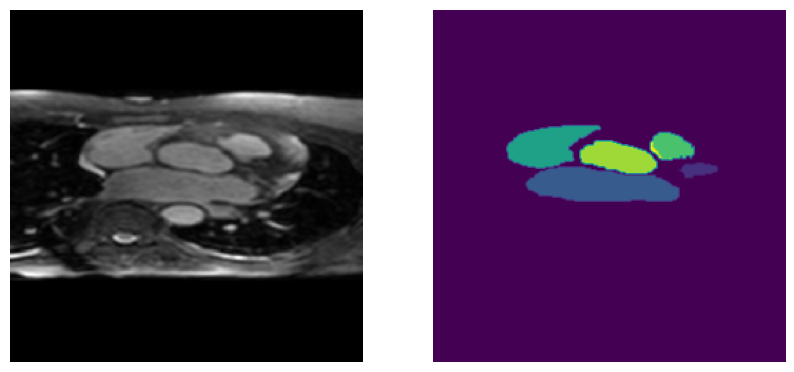

In [11]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(example_im_case, cmap="gray")
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(example_label_case)

In [12]:
filename_ax = "../preprocessed/mr_examples/images/slice_axial_15.nii.gz"
example_im_ax = LoadImage(image_only=True, simple_keys=True)(filename_ax)
print(f"image data shape: {example_im_ax.shape}")

filename_ax = "../preprocessed/mr_examples/labels/slice_axial_15.nii.gz"
example_label_ax = LoadImage(image_only=True, simple_keys=True)(filename_ax)
print(f"label data shape: {example_label_ax.shape}")

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


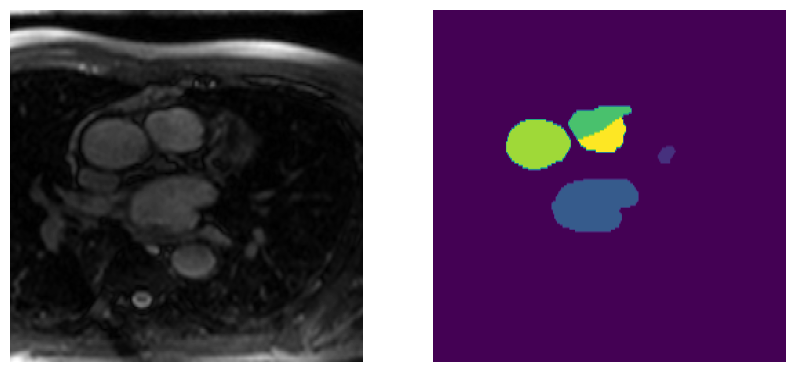

In [13]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(example_im_ax, cmap="gray")
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(example_label_ax)

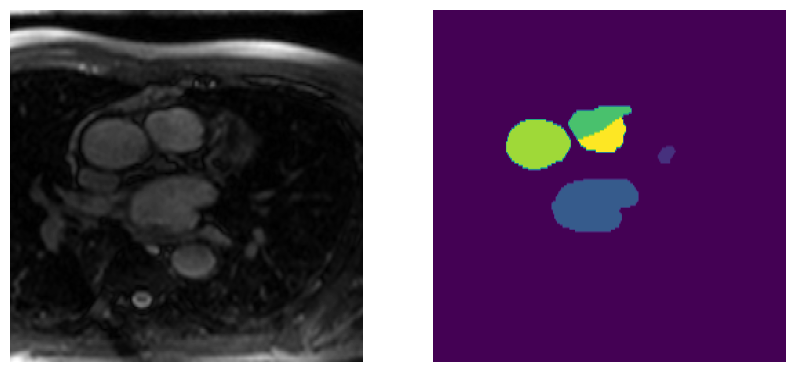

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(example_im_ax, cmap="gray")
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(example_label_ax)